In [1]:
import glob
import os
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import scienceplots
import seaborn as sns
import re
from pathlib import Path
import json
plt.style.use(["science", "no-latex"])
my_style = {
    "text.usetex": False,
    "figure.constrained_layout.use": True,
    "figure.autolayout": False,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.015,
    "font.size": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "axes.titlesize": 12,
}
plt.rcParams.update(my_style)

In [2]:
dataset_order = [
    "sinusoidal",
    "bent",
    "mnist",
    "fmnist",
    "breast",
    "derma",
    "oct",
    "organa",
    "organc",
    "organs",
    "path",
    "pneumonia",
    "retina",
    "blood",
    "chest",
    "tissue",
]


def get_simple_name(dataset_name):
    dataset_name = dataset_name.replace("mnist","") if dataset_name not in ("mnist","fmnist") else dataset_name
    return dataset_name


def read_metrics_csv_files(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name
        
        
        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"
        
        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open('r') as info_file:
                experiment_info = json.load(info_file)
   
        dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["N"] = experiment_info["pca_n_components"]
        df["Method"] = df["Method"].apply(lambda s: s.split()[0])       
        df["Split"] = "train" if "_train" in file_path else "test"
        # Query existing levels
        current_levels = list(df.index.names)
        df = df.set_index(["Dataset","N", "Split"])
        # Create MultiIndex columns
        df = df.pivot(columns="Method", values=["NMSE", "PSNR", "SSI"])
        df.rename(columns={"NMSE": "NRMSE", "SSI":"SSIM"}, level=0, inplace=True)
        

        # Sort column labels
        df = df.sort_index(axis=1)   
        all_data.append(df)
        

    return pd.concat(all_data).sort_index(level=0, key= lambda idx: [dataset_order.index(x) for x in idx.get_level_values('Dataset')],sort_remaining=True)

In [3]:
def read_class_csv_files(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name
        
        
        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"
        
        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open('r') as info_file:
                experiment_info = json.load(info_file)
    
        dataset_name = dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file, header=[0, 1], index_col=[0, 1])
        # Query existing levels
        current_levels = list(df.index.names)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["N"] = experiment_info["pca_n_components"]
        df = df.set_index(["Dataset","N"], append=True)
        df = df.reorder_levels(["Dataset","N"] + current_levels)
        all_data.append(df)

    df = pd.concat(all_data)
    df.columns.set_names("Method", level=1, inplace=True)
    df.rename(columns={"PCA": "PCA"}, level=1, inplace=True)
    df.rename(columns={"Accuracy": "ACC", "F1-Score":"F1"}, level=0, inplace=True)    
    df = df[df.index.get_level_values('Classifier') != 'Gaussian Naive Bayes']
    df = df[["ACC","F1"]]
    df.index = df.index.set_levels(df.index.levels[3].str.lower(), level='Split')
    return df.sort_index(level=0, key= lambda idx: [dataset_order.index(x) for x in idx.get_level_values('Dataset')],sort_remaining=True)

In [4]:
def read_loss_interaction_csv_files(file_pattern):
    all_data = []
    for file_path in glob.glob(file_pattern):
        file = Path(file_path)
        full_dataset_name = file.parent.name
        
        
        # Construct the path to experiment_info.json
        experiment_info_path = file.parent / "experiment_info.json"
        
        # Open and read experiment_info.json
        if experiment_info_path.exists():
            with experiment_info_path.open('r') as info_file:
                experiment_info = json.load(info_file)
   
        dataset_name = full_dataset_name.split("_")[0]
        df = pd.read_csv(file)
        df["Dataset"] = get_simple_name(dataset_name)  # Add a new column with constant value
        df["losses"] = "$\\frac{" + df["loss1"] + "}{" + df["loss2"] + "}$"
        df = df.drop(["loss1","loss2"], axis=1)
        # # Query existing levels
        # current_levels = list(df.index.names)
        # df = df.set_index(["Dataset","N", "Split"])
        # # Create MultiIndex columns
        # df = df.pivot(columns="Method", values=["NMSE", "PSNR", "SSI"])
        # df.rename(columns={"NMSE": "NRMSE", "SSI":"SSIM"}, level=0, inplace=True)
        

        # Sort column labels
        # df = df.sort_index(axis=1)   
        all_data.append(df)
        

    #return pd.concat(all_data).sort_index(level=0, key= lambda idx: [dataset_order.index(x) for x in idx.get_level_values('Dataset')],sort_remaining=True)
    return pd.concat(all_data)

In [5]:
experiment = "experiments_64x64_5"

In [6]:
df_metrics = read_metrics_csv_files(f"{experiment}/*/image_metrics_*.csv")
df_metrics.head(6)

NRMSE             PSNR             SSIM        
Method                  PCA   POLCA      PCA    POLCA     PCA   POLCA
Dataset    N  Split                                                  
sinusoidal 8  test   0.1861  0.0106  20.6031  46.1339  0.8398  0.9993
              train  0.1870  0.0035  20.5149  54.4994  0.8384  0.9999
bent       46 test   0.3321  0.0329  14.7068  36.1388  0.6081  0.9951
              train  0.3117  0.0044  15.2908  52.3087  0.6681  1.0000
mnist      11 test   0.5454  0.3014  15.1314  20.4536  0.5013  0.8047
              train  0.5531  0.2970  15.0848  20.6234  0.4956  0.8085

In [7]:
df_class = read_class_csv_files(f"{experiment}/*/classification_metrics_*.csv")
df_class.head(12)

ACC                  F1          
Method                                     PCA     POLCA       PCA     POLCA
Dataset N  Classifier          Split                                        
mnist   11 Linear SVM          test   0.847400  0.973400  0.846933  0.973372
                               train  0.843900  0.972533  0.843304  0.972510
           Logistic Regression test   0.810300  0.963600  0.809644  0.963562
                               train  0.806867  0.962150  0.806139  0.962127
           Perceptron          test   0.699300  0.927600  0.692989  0.927703
                               train  0.688783  0.924050  0.680193  0.924109
           Ridge Classifier    test   0.716700  0.921100  0.690928  0.920639
                               train  0.703367  0.914750  0.675769  0.914053
fmnist  8  Linear SVM          test   0.749300  0.795300  0.745900  0.792337
                               train  0.755767  0.808483  0.751449  0.805063
           Logistic Regression test   0.731400  0.778300  0.728105  0.776170
                               train  0.738550  0.788767  0.734449  0.786053

In [8]:
df_class_aggregated = (
    df_class[["ACC", "F1"]].groupby(level=["Dataset","N", "Split"]).mean()
) 
df_class_aggregated.head(6)

ACC                  F1          
Method                PCA     POLCA       PCA     POLCA
Dataset N Split                                        
blood   8 test   0.571763  0.614367  0.555154  0.594449
          train  0.573543  0.603604  0.556239  0.582932
breast  8 test   0.745192  0.740385  0.710066  0.676619
          train  0.743590  0.730769  0.715217  0.682867
chest   8 test   0.487396  0.483763  0.019175  0.020054
          train  0.494463  0.490808  0.019048  0.020728

In [9]:
df_joint = df_metrics.join(df_class_aggregated, how="outer")
df_joint.head(6)

NRMSE             PSNR             SSIM               ACC  \
Method               PCA   POLCA      PCA    POLCA     PCA   POLCA       PCA   
Dataset N  Split                                                               
bent    46 test   0.3321  0.0329  14.7068  36.1388  0.6081  0.9951       NaN   
           train  0.3117  0.0044  15.2908  52.3087  0.6681  1.0000       NaN   
blood   8  test   0.1381  0.1330  19.9512  20.3244  0.5123  0.5401  0.571763   
           train  0.1378  0.1226  19.9714  20.9865  0.5151  0.5632  0.573543   
breast  8  test   0.2566  0.2995  20.4567  21.2718  0.3630  0.4311  0.745192   
           train  0.2567  0.0085  20.6007  55.2320  0.3805  0.9975  0.743590   

                                  F1            
Method               POLCA       PCA     POLCA  
Dataset N  Split                                
bent    46 test        NaN       NaN       NaN  
           train       NaN       NaN       NaN  
blood   8  test   0.614367  0.555154  0.594449  
           train  0.603604  0.556239  0.582932  
breast  8  test   0.740385  0.710066  0.676619  
           train  0.730769  0.715217  0.682867

In [10]:
dataset_order = [
    "sinusoidal",
    "bent",
    "mnist",
    "fmnist",
    "breast",
    "derma",
    "oct",
    "organa",
    "organc",
    "organs",
    "path",
    "pneumonia",
    "retina",
    "blood",
    "chest",
    "tissue",
]
# Sort the DataFrame by dataset
df_latex = df_joint.sort_index(level=0, key= lambda idx: [dataset_order.index(x) for x in idx.get_level_values('Dataset')],sort_remaining=True)
df_latex = df_latex.round(2)



df_latex.head(10)

NRMSE         PSNR         SSIM         ACC          F1  \
Method                PCA POLCA    PCA  POLCA   PCA POLCA   PCA POLCA   PCA   
Dataset    N  Split                                                           
sinusoidal 8  test   0.19  0.01  20.60  46.13  0.84  1.00   NaN   NaN   NaN   
              train  0.19  0.00  20.51  54.50  0.84  1.00   NaN   NaN   NaN   
bent       46 test   0.33  0.03  14.71  36.14  0.61  1.00   NaN   NaN   NaN   
              train  0.31  0.00  15.29  52.31  0.67  1.00   NaN   NaN   NaN   
mnist      11 test   0.55  0.30  15.13  20.45  0.50  0.80  0.77  0.95  0.76   
              train  0.55  0.30  15.08  20.62  0.50  0.81  0.76  0.94  0.75   
fmnist     8  test   0.40  0.28  16.19  19.65  0.47  0.67  0.69  0.74  0.67   
              train  0.40  0.28  16.18  19.76  0.47  0.68  0.69  0.75  0.67   
breast     8  test   0.26  0.30  20.46  21.27  0.36  0.43  0.75  0.74  0.71   
              train  0.26  0.01  20.60  55.23  0.38  1.00  0.74  0.73  0.72   

                           
Method              POLCA  
Dataset    N  Split        
sinusoidal 8  test    NaN  
              train   NaN  
bent       46 test    NaN  
              train   NaN  
mnist      11 test   0.95  
              train  0.94  
fmnist     8  test   0.74  
              train  0.74  
breast     8  test   0.68  
              train  0.68

In [11]:
latex_table = df_latex.to_latex(
    multicolumn_format="c",
    # multirow_align="c",
    # hrules = True,
    caption="""Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM),
    Accuracy and the F1-Score.
    """,
    label="tab:joit_classifier_metrics_comparison",
    position="htbp",
    float_format="%.2f",
    column_format="lcrrlrlrlrlrl",
    na_rep = "",
)
latex_table ="""\\begingroup
\\setlength{\\tabcolsep}{2pt} % Default value: 6pt
""" + latex_table
latex_table = latex_table.replace("\\toprule","\\toprule\n" + r"Hyperparameters: &  \multicolumn{10}{c}{ random seed$=5$, $r=1$, $c=0$, $\alpha=1\mathrm{e}{-2}$, $\beta=1\mathrm{e}{-2}$, $\gamma=1\mathrm{e}{-6}$, $\delta=0$ } \\")
latex_table = latex_table.replace("Split","").replace("Method","")

latex_table = latex_table.replace("Dataset & N","Dataset & \\makecell{Latent\\\\size}")
latex_table = latex_table.replace("ACC","Accurary").replace("F1","F1-score")
latex_table = latex_table.replace("\\label{tab:joit_classifier_metrics_comparison}","\\label{tab:joit_classifier_metrics_comparison}\n \\centering \n \\small\n")
latex_table = re.sub("multirow.t.", "multirow[c]", latex_table)
#latex_table = re.sub(r"\\cline..-...", "", latex_table)
latex_table = re.sub(r"\\cline{1-13} \\cline{2-13}", r"\\cmidrule{4-13}", latex_table)
latex_table = re.sub(r"NaN", "", latex_table)
latex_table += "\\endgroup"
print(latex_table)

\begingroup
\setlength{\tabcolsep}{2pt} % Default value: 6pt
\begin{table}[htbp]
\caption{Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSNR), Structural Similarity Index Metric (SSIM),
    Accuracy and the F1-score-Score.
    }
\label{tab:joit_classifier_metrics_comparison}
 \centering 
 \small

\begin{tabular}{lcrrlrlrlrlrl}
\toprule
Hyperparameters: &  \multicolumn{10}{c}{ random seed$=5$, $r=1$, $c=0$, $\alpha=1\mathrm{e}{-2}$, $\beta=1\mathrm{e}{-2}$, $\gamma=1\mathrm{e}{-6}$, $\delta=0$ } \\
 &  &  & \multicolumn{2}{c}{NRMSE} & \multicolumn{2}{c}{PSNR} & \multicolumn{2}{c}{SSIM} & \multicolumn{2}{c}{Accurary} & \multicolumn{2}{c}{F1-score} \\
 &  &  & PCA & POLCA & PCA & POLCA & PCA & POLCA & PCA & POLCA & PCA & POLCA \\
Dataset & \makecell{Latent\\size} &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{2}{*}{sinusoidal} & \multirow[c]{2}{*}{8} & test & 0.19 & 0.01 

In [12]:
# Reshape the DataFrame to long format
df_class_long = (
    df_class.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_4": "Metric", "level_6": "Method", 0: "Value"})
)

df_class_long = pd.DataFrame(df_class_long[df_class_long["Metric"] == "ACC"].copy())
df_class_long.head(10)

,Dataset,N,Classifier,Split,Metric,Method,Value
0,mnist,11,Linear SVM,test,ACC,PCA,0.847400
1,mnist,11,Linear SVM,test,ACC,POLCA,0.973400
4,mnist,11,Linear SVM,train,ACC,PCA,0.843900
5,mnist,11,Linear SVM,train,ACC,POLCA,0.972533
8,mnist,11,Logistic Regression,test,ACC,PCA,0.810300
9,mnist,11,Logistic Regression,test,ACC,POLCA,0.963600
12,mnist,11,Logistic Regression,train,ACC,PCA,0.806867
13,mnist,11,Logistic Regression,train,ACC,POLCA,0.962150
16,mnist,11,Perceptron,test,ACC,PCA,0.699300
17,mnist,11,Perceptron,test,ACC,POLCA,0.927600


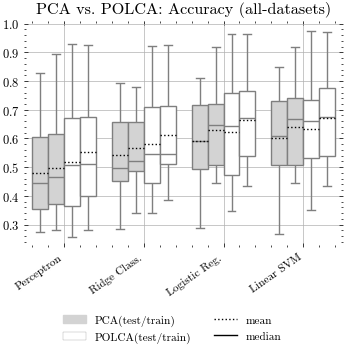

In [13]:
classifier_means = df_class_long.groupby("Classifier")["Value"].mean().sort_values(ascending=True)
classifier_ranks = {classifier: rank for rank, classifier in enumerate(classifier_means.index)}
df_sorted = df_class_long.sort_values(
    by=["Classifier", "Method"], key=lambda x: x.map(classifier_ranks) if x.name == "Classifier" else x
)
df = df_sorted.reset_index(drop=True).copy()

df["Method"] = df["Method"] + "-" + df["Split"]
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.boxplot(
    data=df,
    x="Classifier",
    y="Value",
    hue="Method",
    fill=True,
    palette=["lightgray", "lightgray", "white", "white"],
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
)
plt.xlabel("")
# ax.set_ylabel("Accuary across all datasets", fontsize="small")
ax.set_ylabel(None)
ax.set_xticks(range(len(df.Classifier.unique())))
ax.legend([])
tlabels = [t.get_text() for t in ax.get_xticklabels()]
# tlabels[tlabels.index("Gaussian Naive Bayes")] = "Gauss. NB"
tlabels[tlabels.index("Logistic Regression")] = "Logistic Reg."
tlabels[tlabels.index("Ridge Classifier")] = "Ridge Class."
ax.set_xticklabels(tlabels, rotation=35, ha="right", fontsize="xx-small")
ax.set_title("PCA vs. POLCA: Accuracy (all-datasets)", fontsize="small")
ax.grid()

PCA_patch = mpatches.Patch(color="lightgray", label="PCA(test/train)")
POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA(test/train)", edgecolor="k", lw=0.1)
means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median")

fig.legend(
    handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
    loc="outside lower center",
    fontsize="xx-small",
    ncols=2,
    borderaxespad=0.0,
)

sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/classifier_metric_comparison_boxplot_methods.pdf", dpi=300, bbox_inches="tight")

In [14]:
# Reshape the DataFrame
df_metrics_long = (
    df_metrics.stack(level=[0, 1], future_stack=True)
    .reset_index()
    .rename(columns={"level_3": "Metric", "level_4": "Method", 0: "Value"})
)
df_metrics_long

,Dataset,N,Split,Metric,Method,Value
0,sinusoidal,8,test,NRMSE,PCA,0.1861
1,sinusoidal,8,test,NRMSE,POLCA,0.0106
2,sinusoidal,8,test,PSNR,PCA,20.6031
3,sinusoidal,8,test,PSNR,POLCA,46.1339
4,sinusoidal,8,test,SSIM,PCA,0.8398
...,...,...,...,...,...,...
187,tissue,8,train,NRMSE,POLCA,0.3662
188,tissue,8,train,PSNR,PCA,26.9254
189,tissue,8,train,PSNR,POLCA,27.4838
190,tissue,8,train,SSIM,PCA,0.6539


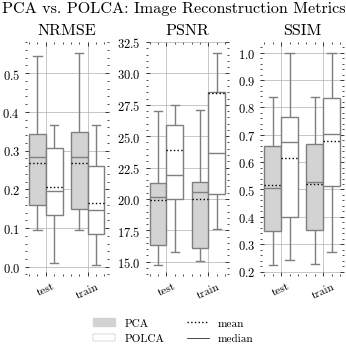

In [15]:
df = df_metrics_long
fig, axs = plt.subplots(1, 3, figsize=(3.5, 3.5))

for ax, metric, title in zip(axs, ["NRMSE", "PSNR", "SSIM"], ["NRMSE", "PSNR", "SSIM"]):
    ax = sns.boxplot(
        data=df[df["Metric"] == metric],
        x="Split",
        y="Value",
        hue="Method",
        fill=True,
        palette={"PCA": "lightgray", "POLCA": "white"},
        gap=0.0,
        showmeans=True,
        meanprops={"ls": ":", "c": "k"},
        meanline=True,
        showfliers=False,
        fliersize=0.5,
        ax=ax,
        legend=False,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title, fontsize="small")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["test", "train"], rotation=25, ha="center", fontsize="xx-small")
    ax.grid()


plt.suptitle("PCA vs. POLCA: Image Reconstruction Metrics", fontsize="small")

PCA_patch = mpatches.Patch(color="lightgray", label="PCA")
POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA", edgecolor="k", lw=0.1)
means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median", lw=0.5)

fig.legend(
    handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
    loc="outside lower center",
    fontsize="xx-small",
    ncols=2,
    borderaxespad=0.0,
)
# Tweak the visual presentation
sns.despine(trim=True, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/image_metrics_comparison_boxplot.pdf", dpi=300, bbox_inches="tight")

In [16]:
df_class_labels = read_class_csv_files(f"experiments_64x64_5_labels/*/classification_metrics_*.csv")
df_class_labels = df_class_labels.xs('POLCA', axis=1, level=1)
df_class_labels.head(20)

ACC        F1
Dataset N  Classifier          Split                    
mnist   11 Linear SVM          test   0.989400  0.989398
                               train  0.994583  0.994582
           Logistic Regression test   0.989300  0.989299
                               train  0.993700  0.993700
           Perceptron          test   0.986300  0.986292
                               train  0.989200  0.989183
           Ridge Classifier    test   0.973800  0.973738
                               train  0.976233  0.976212
fmnist  8  Linear SVM          test   0.808600  0.806451
                               train  0.819967  0.817723
           Logistic Regression test   0.804100  0.801943
                               train  0.814183  0.811625
           Perceptron          test   0.715900  0.691082
                               train  0.722783  0.699872
           Ridge Classifier    test   0.722900  0.711765
                               train  0.729650  0.719358
breast  8  Linear SVM          test   0.801282  0.798892
                               train  1.000000  1.000000
           Logistic Regression test   0.801282  0.798892
                               train  1.000000  1.000000

In [17]:
df_class_labels_aggregated = (
    df_class_labels.groupby(level=["Dataset", "Split"]).mean().round(2)
) 
df_class_labels_aggregated

ACC    F1
Dataset   Split            
blood     test   0.77  0.74
          train  0.78  0.76
breast    test   0.80  0.80
          train  1.00  1.00
chest     test   0.50  0.02
          train  0.51  0.02
derma     test   0.72  0.69
          train  1.00  0.99
fmnist    test   0.76  0.75
          train  0.77  0.76
mnist     test   0.98  0.98
          train  0.99  0.99
oct       test   0.36  0.25
          train  0.61  0.55
organa    test   0.73  0.72
          train  0.84  0.83
organc    test   0.74  0.73
          train  0.81  0.80
organs    test   0.56  0.53
          train  0.66  0.62
path      test   0.64  0.61
          train  0.64  0.63
pneumonia test   0.83  0.82
          train  1.00  1.00
retina    test   0.46  0.42
          train  1.00  1.00
tissue    test   0.41  0.31
          train  0.41  0.31

In [18]:
latex_table = df_class_labels_aggregated.to_latex(
    multicolumn_format="c",
    # multirow_align="c",
    # hrules = True,
    caption="""Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSRN), Structural Similarity Index Metric,
    Accuracy (ACC) and F1-Score (F1).
    """,
    label="tab:joit_classifier_metrics_comparison",
    position="htbp",
    float_format="%.2f",
)
latex_table = latex_table.replace("\\label{tab:joit_classifier_metrics_comparison}","\\label{tab:joit_classifier_metrics_comparison}\n \\centering \n \\small\n")
latex_table = re.sub("multirow.t.", "multirow[c]", latex_table)
latex_table = re.sub(r"\\cline..-...", "", latex_table)
latex_table = re.sub(r"NaN", "", latex_table)

print(latex_table)

\begin{table}[htbp]
\caption{Classification Metrics averaged across all Datasets and Image Reconstruction Metris:
    Normalized Root-Mean-Square (NRMSE), Peak Signal to Noise Ratio (PSRN), Structural Similarity Index Metric,
    Accuracy (ACC) and F1-Score (F1).
    }
\label{tab:joit_classifier_metrics_comparison}
 \centering 
 \small

\begin{tabular}{llrr}
\toprule
 &  & ACC & F1 \\
Dataset & Split &  &  \\
\midrule
\multirow[c]{2}{*}{blood} & test & 0.77 & 0.74 \\
 & train & 0.78 & 0.76 \\
\cline{1-4}
\multirow[c]{2}{*}{breast} & test & 0.80 & 0.80 \\
 & train & 1.00 & 1.00 \\
\cline{1-4}
\multirow[c]{2}{*}{chest} & test & 0.50 & 0.02 \\
 & train & 0.51 & 0.02 \\
\cline{1-4}
\multirow[c]{2}{*}{derma} & test & 0.72 & 0.69 \\
 & train & 1.00 & 0.99 \\
\cline{1-4}
\multirow[c]{2}{*}{fmnist} & test & 0.76 & 0.75 \\
 & train & 0.77 & 0.76 \\
\cline{1-4}
\multirow[c]{2}{*}{mnist} & test & 0.98 & 0.98 \\
 & train & 0.99 & 0.99 \\
\cline{1-4}
\multirow[c]{2}{*}{oct} & test & 0.36 & 0.25 \\


In [19]:
# Reshape the DataFrame to long format
df_class_labels_long = df_class_labels.reset_index()
df_class_labels_long.head(30)

,Dataset,N,Classifier,Split,ACC,F1
0,mnist,11,Linear SVM,test,0.989400,0.989398
1,mnist,11,Linear SVM,train,0.994583,0.994582
2,mnist,11,Logistic Regression,test,0.989300,0.989299
3,mnist,11,Logistic Regression,train,0.993700,0.993700
4,mnist,11,Perceptron,test,0.986300,0.986292
5,mnist,11,Perceptron,train,0.989200,0.989183
6,mnist,11,Ridge Classifier,test,0.973800,0.973738
7,mnist,11,Ridge Classifier,train,0.976233,0.976212
8,fmnist,8,Linear SVM,test,0.808600,0.806451
9,fmnist,8,Linear SVM,train,0.819967,0.817723


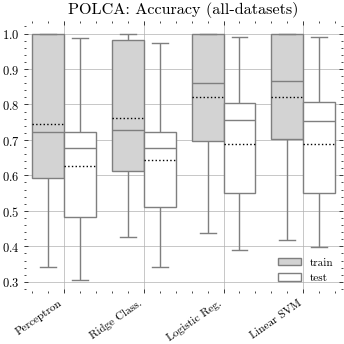

In [20]:
classifier_means = df_class_labels_long.groupby("Classifier")["ACC"].mean().sort_values(ascending=True)
classifier_ranks = {classifier: rank for rank, classifier in enumerate(classifier_means.index)}
df_sorted = df_class_labels_long.sort_values(
    by=["Classifier"], key=lambda x: x.map(classifier_ranks) if x.name == "Classifier" else x
)
df = df_sorted.reset_index(drop=True).copy()

# df["Method"] = df["Method"] + "-" + df["Split"]
fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.boxplot(
    data=df,
    x="Classifier",
    y="ACC",
    hue="Split",
    fill=True,
    palette=["lightgray",  "white"],
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
)
plt.xlabel("")
# ax.set_ylabel("Accuary across all datasets", fontsize="small")
ax.set_ylabel(None)
ax.set_xticks(range(len(df.Classifier.unique())))
ax.legend(loc="lower right")
tlabels = [t.get_text() for t in ax.get_xticklabels()]
# tlabels[tlabels.index("Gaussian Naive Bayes")] = "Gauss. NB"
tlabels[tlabels.index("Logistic Regression")] = "Logistic Reg."
tlabels[tlabels.index("Ridge Classifier")] = "Ridge Class."
ax.set_xticklabels(tlabels, rotation=35, ha="right", fontsize="xx-small")
ax.set_title("POLCA: Accuracy (all-datasets)", fontsize="small")
ax.grid()

# PCA_patch = mpatches.Patch(color="lightgray", label="PCA(test/train)")
# POLCA_patch = mpatches.Patch(facecolor="white", label="POLCA(test/train)", edgecolor="k", lw=0.1)
# means_leg = mlines.Line2D([], [], ls=":", color="k", marker=None, markersize=15, label="mean")
# median_leg = mlines.Line2D([], [], ls="-", color="k", marker=None, markersize=15, label="median")

# fig.legend(
#     handles=[PCA_patch, POLCA_patch, means_leg, median_leg],
#     loc="outside lower center",
#     fontsize="xx-small",
#     ncols=2,
#     borderaxespad=0.0,
# )

sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/classifier_metric_comparison_boxplot_methods.pdf", dpi=300, bbox_inches="tight")

In [21]:
(64*64)**(1/4)

8.0

In [22]:
df_loss = read_loss_interaction_csv_files(f"{experiment}/*/loss_interaction_report.csv")

# Step 1: Find the most common relationship for each unique losses value
most_common_relationship = df_loss.groupby('losses')['relationship'].agg(lambda x: x.value_counts().index[0]).reset_index()

# Step 2: Create a dictionary for mapping
relationship_mapping = most_common_relationship.set_index('losses')['relationship'].to_dict()

# Step 3: Replace the values in the 'relationship' column
df_loss['common_relationship'] = df_loss['losses'].map(relationship_mapping)

# Step 4: Define the order of relationships from worst to best
relationship_order = [
    "Strongly Conflicting",
    "Conflicting",
    "Weakly Conflicting",
    "Weakly Cooperative",
    "Cooperative",
    "Strongly Cooperative"
]

# Step 5: Create a categorical column with the defined order
df_loss['relationship_category'] = pd.Categorical(df_loss['common_relationship'], categories=relationship_order, ordered=True)

# Step 6: Sort the DataFrame based on the categorical column
df_loss = df_loss.sort_values('relationship_category')

# Step 7: Drop the helper column used for sorting
df_loss = df_loss.drop(columns=['relationship_category'])

# df_loss["losses"]  = "$" + df_loss["losses"] + "$"

df_loss

,Unnamed: 0,interactions,conflicts,conflict_rate,avg_similarity,relationship,Dataset,losses,common_relationship
0,0,5216,2755,0.528183,-0.113042,Strongly Conflicting,path,$\frac{com}{var}$,Strongly Conflicting
0,0,4896,1285,0.262459,-0.040319,Weakly Conflicting,organa,$\frac{com}{var}$,Strongly Conflicting
0,0,4703,3820,0.812248,-0.134162,Strongly Conflicting,sinusoidal,$\frac{com}{var}$,Strongly Conflicting
5,5,4786,2,0.000418,0.769964,Strongly Cooperative,bent,$\frac{com}{var}$,Strongly Conflicting
0,0,4873,3578,0.734250,-0.125094,Strongly Conflicting,pneumonia,$\frac{com}{var}$,Strongly Conflicting
...,...,...,...,...,...,...,...,...,...
5,5,4921,39,0.007925,0.248950,Strongly Cooperative,organs,$\frac{ort}{com}$,Strongly Cooperative
5,5,5085,36,0.007080,0.206183,Strongly Cooperative,chest,$\frac{ort}{com}$,Strongly Cooperative
5,5,4919,22,0.004472,0.269241,Strongly Cooperative,organc,$\frac{ort}{com}$,Strongly Cooperative
5,5,5240,5,0.000954,0.242157,Strongly Cooperative,oct,$\frac{ort}{com}$,Strongly Cooperative


In [23]:
df_loss["losses"].unique()

array(['$\\frac{com}{var}$', '$\\frac{rec}{com}$', '$\\frac{rec}{var}$',
       '$\\frac{rec}{ort}$', '$\\frac{ort}{var}$', '$\\frac{ort}{com}$'],
      dtype=object)

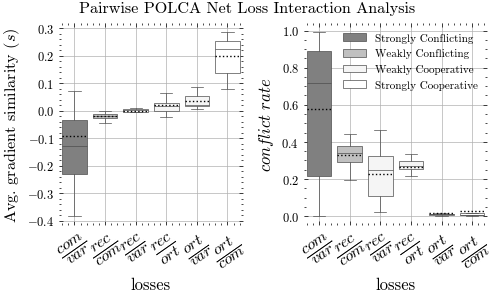

In [29]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(5, 3))
ax1 = sns.boxplot(
    data=df_loss,
    x="losses",
    y="avg_similarity",
    hue="common_relationship",
    fill=True,
    palette=["gray", "silver", "whitesmoke", "white"],
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
    # color="k",  
    linewidth=0.5,
    ax=ax1,
    saturation=0.6,
    
)
ax1.grid()
ax1.set_ylabel("Avg. gradient similarity ($s$)", fontsize="small")
similarity_form = r"$s=\frac{\nabla L_i \cdot \nabla L_j}{|\nabla L_i| |\nabla L_j|}$"
similarity_form += r", $s<1\mathrm{e}{-1}~(\text{conflict})$"
# ax1.set_title(similarity_form,fontsize="medium")
ax1.set_xticks(range(len(df_loss["losses"].unique())))
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=35, ha="center", fontsize="large")
ax1.legend([]);

ax2 = sns.boxplot(
    data=df_loss,
    x="losses",
    y="conflict_rate",
    hue="common_relationship",
    fill=True,
    palette=["gray", "silver", "whitesmoke", "white"],
    showmeans=True,
    meanprops={"ls": ":", "c": "k"},
    meanline=True,
    showfliers=False,
    fliersize=0.5,
    # color="k",  
    linewidth=0.5,
    ax=ax2,
    saturation=0.6,
    
)
ax2.grid()
ax2.set_ylabel("$conflict$ $rate$")
# ax2.set_title("$rate = conflicts / interactions$",fontsize="medium")
ax2.set_xticks(range(len(df_loss["losses"].unique())))
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=35, ha="center", fontsize="large")
ax2.legend();
plt.suptitle("Pairwise POLCA Net Loss Interaction Analysis",fontsize="small")
sns.despine(trim=False, left=True, right=True, top=True, bottom=True)
plt.savefig(f"{experiment}/pairwise_loss_conflicts_boxplot.pdf", dpi=300, bbox_inches="tight")